In [23]:
import kagglehub
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import randint

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from joblib import dump

In [24]:
dataset_slug = "benjnb/cars-for-sale"
file_name = "Updated_Car_Sales_Data.csv"

df = kagglehub.dataset_load(
  kagglehub.KaggleDatasetAdapter.PANDAS,
  dataset_slug,
  file_name,
)

In [25]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cleaned = X.copy()

        if 'Fuel Type' in X_cleaned.columns:
            X_cleaned['Fuel Type'] = X_cleaned['Fuel Type'].replace('Petrol', 'Gasoline')

        columns_to_drop = ['Car Make', 'Condition']
        cols_to_drop_exist = [col for col in columns_to_drop if col in X_cleaned.columns]
        if cols_to_drop_exist:
            X_cleaned = X_cleaned.drop(cols_to_drop_exist, axis=1)


        return X_cleaned

In [26]:
class TargetEncodeAndScale(BaseEstimator, TransformerMixin):
    def __init__(self, category_col, target_col):
        self.category_col = category_col
        self.target_col = target_col
        self.target_encoder = TargetEncoder(cols=category_col, smoothing=0.2)
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        X_encoded = self.target_encoder.fit_transform(X, y)
        self.scaler.fit(X_encoded[[self.category_col]])
        return self

    def transform(self, X):
        X_encoded = self.target_encoder.transform(X)
        X_scaled = self.scaler.transform(X_encoded[[self.category_col]])
        return X_scaled

    def get_feature_names_out(self, input_features=None):
        return [self.category_col]

In [27]:
def split_features(features_string):
    if isinstance(features_string, str):
        return [feature.strip() for feature in features_string.split(',')]
    return []

In [28]:
class MultiLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

In [29]:
class Label_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.le = LabelEncoder()

    def fit(self, X, y=None):
        self.le.fit(X[self.column])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.column] = self.le.transform(X_[self.column])
        return X_
    def get_feature_names_out(self, input_features=None):
        return [self.column]

In [30]:
def create_preprocessor():
  target = 'Price'
  target_encoder_col = 'Car Model'
  numeric_cols = ['Year', 'Mileage']
  cat_cols = ['Fuel Type', 'Color', 'Transmission']
  multi_label_col = 'Options/Features'
  binary_col = 'Accident'

  preprocessor = ColumnTransformer(
        transformers=[
            ('target_encoder', TargetEncodeAndScale(target_encoder_col, target), [target_encoder_col]),
            ('numeric', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('multi_label', MultiLabelEncoder(), split_features([multi_label_col])),
            ('binary', Label_Encoder(column=binary_col), [binary_col])
        ],
        remainder='drop',
        verbose_feature_names_out=True
    )
  return preprocessor

In [31]:
class SelectKBestTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, score_func=f_regression, k=5):
        self.score_func = score_func
        self.k = k
        self.selector = SelectKBest(score_func=score_func, k=k)
        self.selected_features_indices_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
             X_df = pd.DataFrame(X)
        else:
            X_df = X

        self.selector.fit(X_df, y)
        self.selected_features_indices_ = self.selector.get_support(indices=True)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
             X_df = pd.DataFrame(X)
        else:
            X_df = X
        return self.selector.transform(X_df)

    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

In [32]:
def split_data(df, target_column='Price', val_size=0.05, test_size=0.2, random_state=42):
  X = df.drop(columns=[target_column], axis=1)
  y = df[target_column]
  X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=val_size, random_state=random_state)
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=test_size, random_state=random_state)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [34]:
data_cleaner = DataCleaner()
preprocessor = create_preprocessor()
feature_selector = SelectKBestTransformer()

pipeline = Pipeline(steps=[
    ('cleaning', data_cleaner),
    ('preprocessing', preprocessor),
    ('selecting_features', feature_selector)
])

In [35]:
pipeline.fit(X_train, y_train)

preprocessor = pipeline.named_steps['preprocessing']
feature_selector = pipeline.named_steps['selecting_features']

X_train_processed = pipeline.transform(X_train)
X_val_processed = pipeline.transform(X_val)

all_preprocessor_feature_names = preprocessor.get_feature_names_out()

selected_feature_indices = feature_selector.get_support(indices=True)

selected_feature_names = all_preprocessor_feature_names[selected_feature_indices]


X_train_processed = pd.DataFrame(X_train_processed, columns=selected_feature_names)
X_val_processed = pd.DataFrame(X_val_processed, columns=selected_feature_names)

display(X_train_processed.head())

,target_encoder__Car Model,numeric__Year,numeric__Mileage,cat__Color_Orange,binary__Accident
0,-0.419230,-0.637714,-1.104400,1.0,1.0
1,-0.410615,0.961221,-1.239424,0.0,1.0
2,-0.414303,0.694732,-1.413073,0.0,1.0
3,-0.406277,0.961221,-0.931310,0.0,1.0
4,-0.423583,-0.904203,0.428679,0.0,1.0


In [36]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

In [37]:
trained_models = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    trained_models[name] = model

In [38]:
for name, model in trained_models.items():
    y_pred = trained_models[name].predict(X_val_processed)

In [39]:
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'rmse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

cv_results = {}

for name, model in trained_models.items():
    from sklearn.model_selection import cross_validate
    cv_metrics = cross_validate(model, X_train_processed, y_train, cv=5, scoring=scoring)

    cv_results[name] = {
        "Mean MAE (CV)": cv_metrics['test_mae'].mean(),
        "Std Dev MAE (CV)": cv_metrics['test_mae'].std(),
        "Mean MSE (CV)": cv_metrics['test_mse'].mean(),
        "Std Dev MSE (CV)": cv_metrics['test_mse'].std(),
        "Mean RMSE (CV)": np.sqrt(cv_metrics['test_mse'].mean()),
        "Std Dev RMSE (CV)": cv_metrics['test_rmse'].std(),
        "Mean R² (CV)": cv_metrics['test_r2'].mean(),
        "Std Dev R² (CV)": cv_metrics['test_r2'].std()
    }

cv_df = pd.DataFrame(cv_results).T
display(cv_df.sort_values(by='Mean R² (CV)', ascending=False))

,Mean MAE (CV),Std Dev MAE (CV),Mean MSE (CV),Std Dev MSE (CV),Mean RMSE (CV),Std Dev RMSE (CV),Mean R² (CV),Std Dev R² (CV)
KNN,16648.231017,258.325527,8.142053e+08,1.571368e+07,28534.282224,1.571368e+07,0.803443,0.004892
Linear Regression,17928.527524,429.034729,9.199147e+08,6.172741e+07,30330.094808,6.172741e+07,0.778255,0.008946
Decision Tree,21068.505126,234.875023,1.390427e+09,4.097190e+07,37288.432614,4.097190e+07,0.664371,0.010003


In [40]:
pipeline_to_tune_knn = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor()),
    ('selecting_features', SelectKBestTransformer()),
    ('regressor', KNeighborsRegressor())
])

param_distributions_knn = {
    'regressor__n_neighbors': randint(1, 20)
}

random_search_knn = RandomizedSearchCV(
    pipeline_to_tune_knn,
    param_distributions=param_distributions_knn,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search_knn.fit(X_train, y_train)

best_params_knn = random_search_knn.best_params_
best_score_knn = -random_search_knn.best_score_

print("\nBest hyperparameters for KNN pipeline:", best_params_knn)
print("Best Mean MSE from cross-validation (KNN pipeline):", best_score_knn)

best_pipeline_knn = random_search_knn.best_estimator_

pipeline_to_tune_dt = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor()),
    ('selecting_features', SelectKBestTransformer()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_distributions_dt = {
    'regressor__max_depth': randint(1, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 20)
}

random_search_dt = RandomizedSearchCV(
    pipeline_to_tune_dt,
    param_distributions=param_distributions_dt,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_dt.fit(X_train, y_train)

best_params_dt = random_search_dt.best_params_
best_score_dt = -random_search_dt.best_score_

print("\nBest hyperparameters for Decision Tree pipeline:", best_params_dt)
print("Best Mean MSE from cross-validation (Decision Tree pipeline):", best_score_dt)

best_pipeline_dt = random_search_dt.best_estimator_


tuned_models_evaluation = {}

y_pred_tuned_knn = best_pipeline_knn.predict(X_val)
mae_tuned_knn = mean_absolute_error(y_val, y_pred_tuned_knn)
mse_tuned_knn = mean_squared_error(y_val, y_pred_tuned_knn)
rmse_tuned_knn = np.sqrt(mse_tuned_knn)
r2_tuned_knn = r2_score(y_val, y_pred_tuned_knn)

tuned_models_evaluation["Tuned KNN"] = {
    "MAE": mae_tuned_knn,
    "MSE": mse_tuned_knn,
    "RMSE": rmse_tuned_knn,
    "R²": r2_tuned_knn
}

y_pred_tuned_dt = best_pipeline_dt.predict(X_val)
mae_tuned_dt = mean_absolute_error(y_val, y_pred_tuned_dt)
mse_tuned_dt = mean_squared_error(y_val, y_pred_tuned_dt)
rmse_tuned_dt = np.sqrt(mse_tuned_dt)
r2_tuned_dt = r2_score(y_val, y_pred_tuned_dt)

tuned_models_evaluation["Tuned Decision Tree"] = {
    "MAE": mae_tuned_dt,
    "MSE": mse_tuned_dt,
    "RMSE": rmse_tuned_dt,
    "R²": r2_tuned_dt
}

tuned_evaluation_df = pd.DataFrame(tuned_models_evaluation).T
print("\nComparison of Tuned Models on Validation Set:")
display(tuned_evaluation_df.sort_values(by='R²', ascending=False))


Best hyperparameters for KNN pipeline: {'regressor__n_neighbors': 19}
Best Mean MSE from cross-validation (KNN pipeline): 735078349.9446439

Best hyperparameters for Decision Tree pipeline: {'regressor__max_depth': 6, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2}
Best Mean MSE from cross-validation (Decision Tree pipeline): 715686399.5583333

Comparison of Tuned Models on Validation Set:


,MAE,MSE,RMSE,R²
Tuned Decision Tree,15285.734492,6.457508e+08,25411.626544,0.838829
Tuned KNN,15766.628129,7.048167e+08,26548.384563,0.824087


In [41]:
y_pred_test = best_pipeline_dt.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nFinal Evaluation Results on Test Set (Best Tuned Decision Tree Pipeline):")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²): {r2_test:.4f}")


Final Evaluation Results on Test Set (Best Tuned Decision Tree Pipeline):
Mean Absolute Error (MAE): 15262.30
Mean Squared Error (MSE): 676769070.34
Root Mean Squared Error (RMSE): 26014.79
R-squared (R²): 0.8432


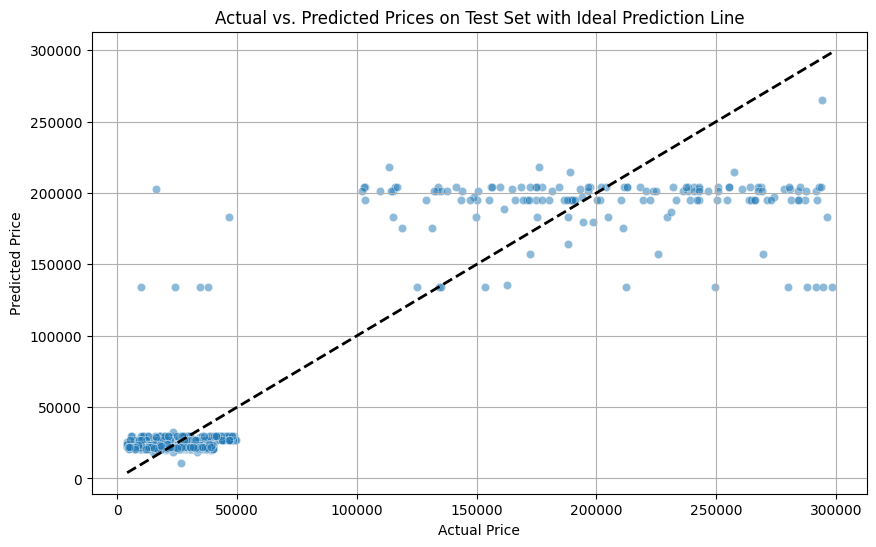

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Prices on Test Set with Ideal Prediction Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [43]:
model_filename = '../models/model.pkl'

dump(best_pipeline_dt, model_filename)

['../models/model.pkl']